In [1]:
import pandas as pd
import os
import pyarrow.parquet as pq
import logging

In [3]:
parquet_folder_path = "data_clean"

df_dict = {}
dfs = []

for file in os.listdir(parquet_folder_path):
    if file.endswith(".parquet"):
        filepath = os.path.join(parquet_folder_path,file)

        table = pq.read_table(filepath)
        df = table.to_pandas()
        df_dict[file] = df
        dfs.append(df)


combined_df = pd.concat(dfs, ignore_index=True)

In [6]:
df_dict['clean_yellow_tripdata_2023-06.parquet'].head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,...,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee,airport_fee,trip_duration_minutes,average_speed_mph,pickup_date,pickup_hour,pickup_weekday
0,1,2023-06-01 00:48:24,2023-06-01 01:07:07,1.0,10.20,1,False,138,97,1,...,1.0,60.05,0.0,1.75,0,18.716667,32.698130,2023-06-01,0,Thursday
1,2,2023-06-01 00:54:03,2023-06-01 01:17:29,3.0,9.83,1,False,100,244,1,...,1.0,53.28,2.5,0.00,0,23.433333,25.169275,2023-06-01,0,Thursday
2,2,2023-06-01 00:18:44,2023-06-01 00:27:18,1.0,1.17,1,False,137,234,1,...,1.0,15.02,2.5,0.00,0,8.566667,8.194553,2023-06-01,0,Thursday
3,2,2023-06-01 00:31:55,2023-06-01 00:50:51,1.0,3.08,1,False,141,226,1,...,1.0,26.80,2.5,0.00,0,18.933333,9.760563,2023-06-01,0,Thursday
4,2,2023-06-01 00:11:50,2023-06-01 00:15:47,1.0,0.99,1,False,186,234,1,...,1.0,13.22,2.5,0.00,0,3.950000,15.037975,2023-06-01,0,Thursday


In [9]:
combined_df.shape

(12924426, 25)

In [10]:
df_dict['clean_yellow_tripdata_2023-06.parquet'].shape


(2155624, 25)

In [11]:
combined_df.columns

Index(['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'RatecodeID', 'store_and_fwd_flag',
       'PULocationID', 'DOLocationID', 'payment_type', 'fare_amount', 'extra',
       'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge',
       'total_amount', 'congestion_surcharge', 'airport_fee',
       'trip_duration_minutes', 'average_speed_mph', 'pickup_date',
       'pickup_hour', 'pickup_weekday', 'Airport_fee'],
      dtype='object')

# Trip Counts by Hour

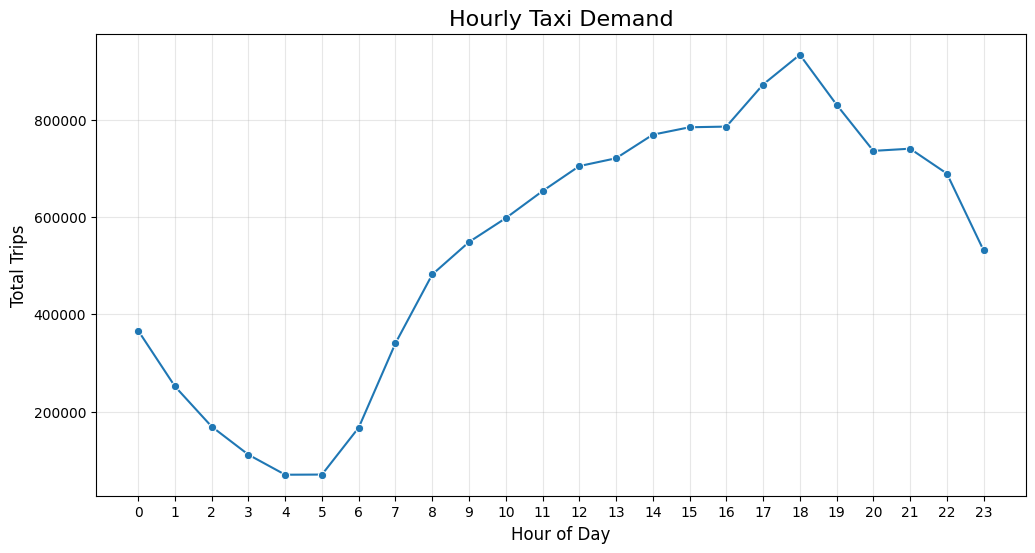

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12,6))
hourly_counts = combined_df.groupby("pickup_hour").size()

sns.lineplot(x=hourly_counts.index, y=hourly_counts.values, marker="o")
plt.title("Hourly Taxi Demand", fontsize=16)
plt.xlabel("Hour of Day", fontsize=12)
plt.ylabel("Total Trips", fontsize=12)
plt.grid(alpha=0.3)
plt.xticks(range(0,24))
plt.show()


# Heatmap: Seasonality (Weekday × Hour)

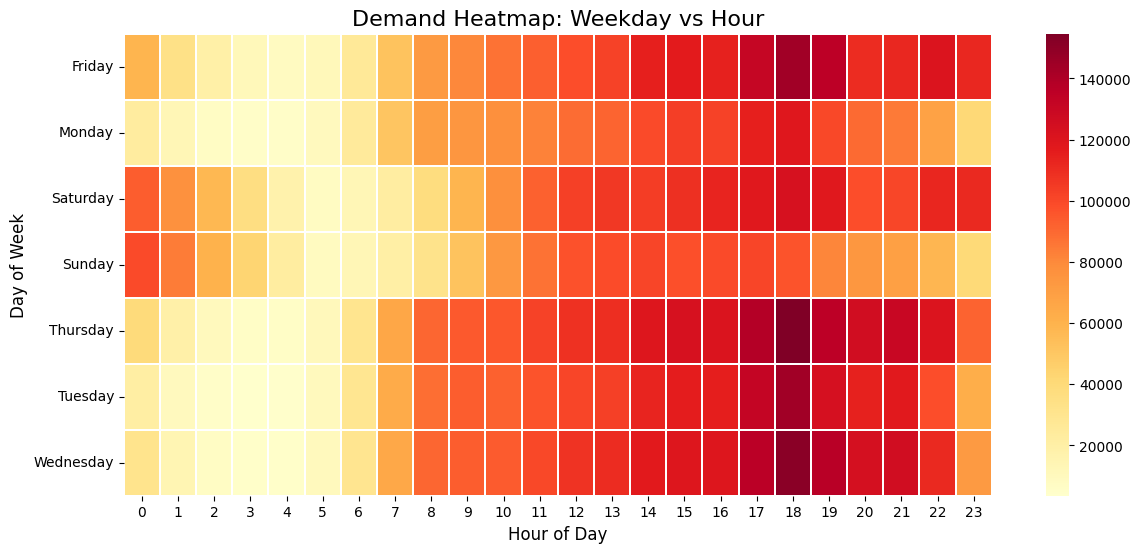

In [25]:
plt.figure(figsize=(14,6))
heatmap_df = combined_df.groupby(["pickup_weekday", "pickup_hour"]).size().unstack()

sns.heatmap(heatmap_df, cmap="YlOrRd", linewidths=.3)
plt.title("Demand Heatmap: Weekday vs Hour", fontsize=16)
plt.xlabel("Hour of Day", fontsize=12)
plt.ylabel("Day of Week", fontsize=12)
plt.show()


# Average Trip Duration & Distance per Hour

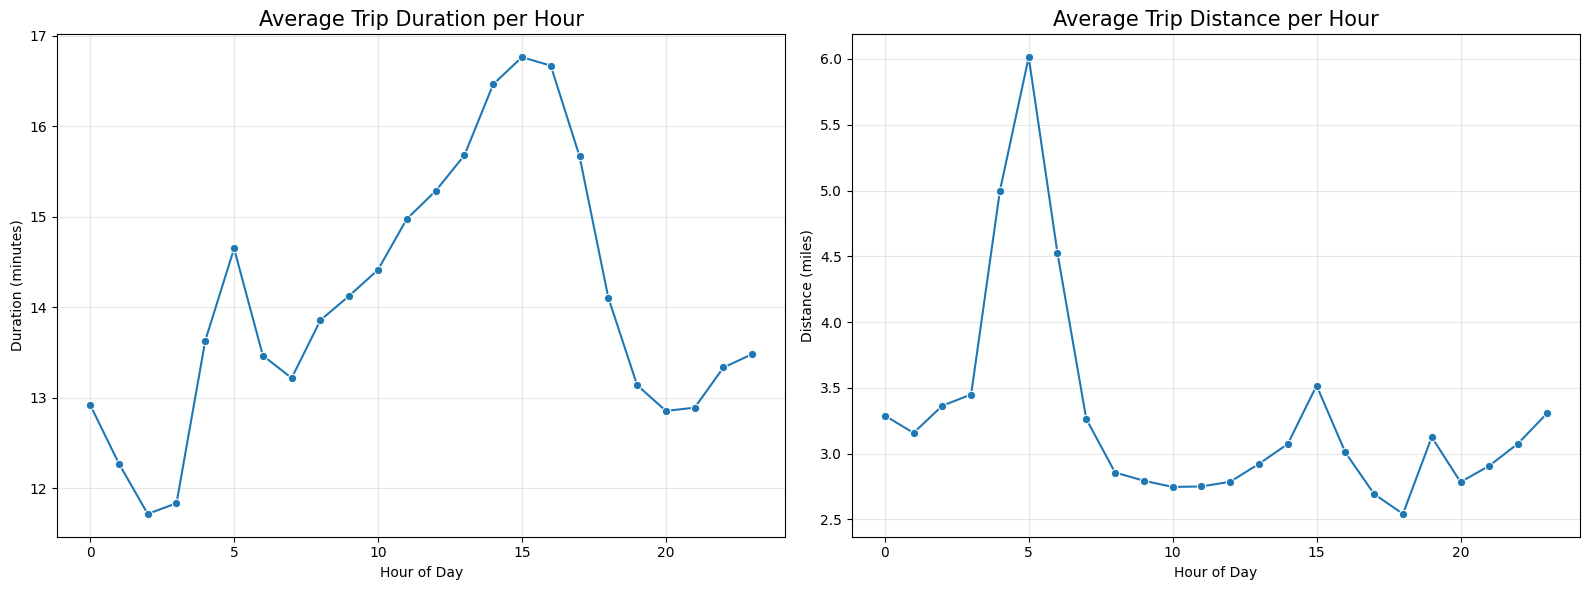

In [26]:
fig, ax = plt.subplots(1, 2, figsize=(16,6))

hourly_duration = combined_df.groupby("pickup_hour")["trip_duration_minutes"].mean()
hourly_distance = combined_df.groupby("pickup_hour")["trip_distance"].mean()

# Duration Chart
sns.lineplot(ax=ax[0], x=hourly_duration.index, y=hourly_duration.values, marker="o")
ax[0].set_title("Average Trip Duration per Hour", fontsize=15)
ax[0].set_xlabel("Hour of Day")
ax[0].set_ylabel("Duration (minutes)")
ax[0].grid(alpha=0.3)

# Distance Chart
sns.lineplot(ax=ax[1], x=hourly_distance.index, y=hourly_distance.values, marker="o")
ax[1].set_title("Average Trip Distance per Hour", fontsize=15)
ax[1].set_xlabel("Hour of Day")
ax[1].set_ylabel("Distance (miles)")
ax[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()


# Shows high-demand hotspots by NYC zone

C:\Users\B I S M I L L A H\AppData\Local\Temp\ipykernel_17584\168555636.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="PULocationID", y="count", data=filtered, palette="viridis")


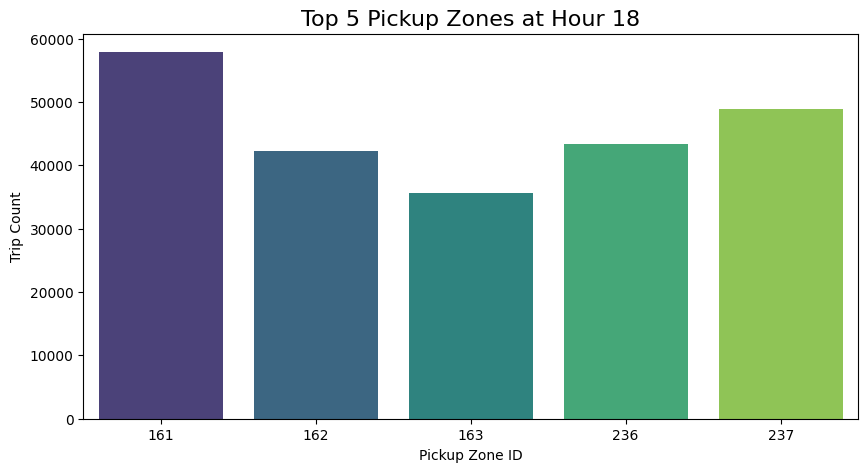

In [27]:
top_zones = (combined_df.groupby(["pickup_hour", "PULocationID"])
                           .size()
                           .reset_index(name="count"))

hour_to_show = 18

filtered = (top_zones[top_zones["pickup_hour"] == hour_to_show]
            .sort_values("count", ascending=False)
            .head(5))

plt.figure(figsize=(10,5))
sns.barplot(x="PULocationID", y="count", data=filtered, palette="viridis")
plt.title(f"Top 5 Pickup Zones at Hour {hour_to_show}", fontsize=16)
plt.xlabel("Pickup Zone ID")
plt.ylabel("Trip Count")
plt.show()


# Compare total rides and average fare between months

In [28]:
combined_df["pickup_month"] = combined_df["pickup_date"].astype(str).str[:7]


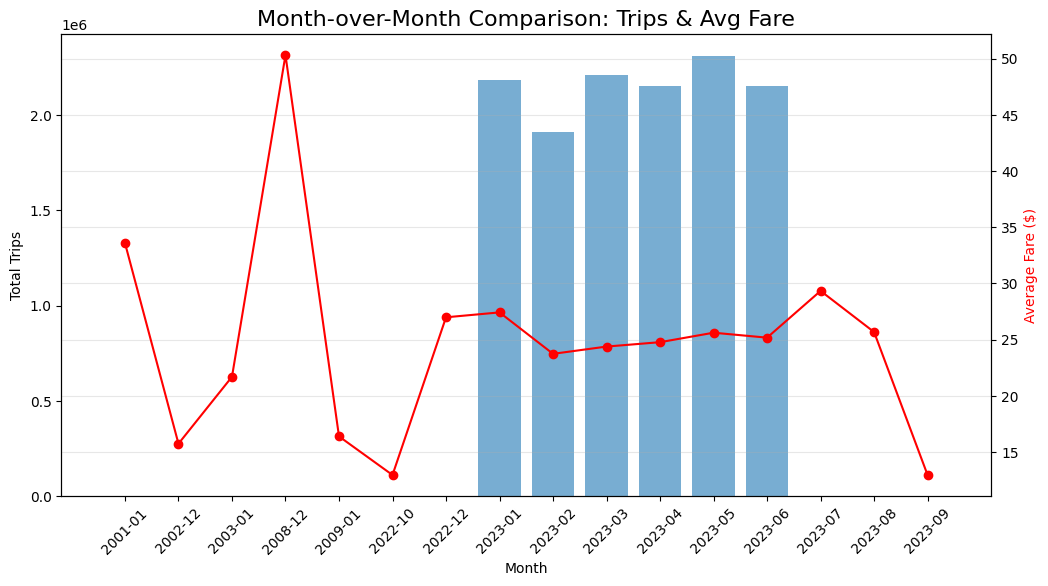

In [29]:
monthly_trips = combined_df.groupby("pickup_month").size()
monthly_fare = combined_df.groupby("pickup_month")["total_amount"].mean()

fig, ax1 = plt.subplots(figsize=(12,6))

# Bar chart for total trips
ax1.bar(monthly_trips.index, monthly_trips.values, alpha=0.6)
ax1.set_xlabel("Month")
ax1.set_ylabel("Total Trips", color="black")
ax1.tick_params(axis='x', rotation=45)

# Line chart for average fare
ax2 = ax1.twinx()
ax2.plot(monthly_fare.index, monthly_fare.values, marker="o", color="red")
ax2.set_ylabel("Average Fare ($)", color="red")

plt.title("Month-over-Month Comparison: Trips & Avg Fare", fontsize=16)
plt.grid(alpha=0.3)
plt.show()


# KPI Calculations

In [32]:
kpi_avg_trips_hour = combined_df.groupby("pickup_hour").size().mean()
kpi_avg_fare_hour = combined_df.groupby("pickup_hour")["total_amount"].mean().mean()

monthly = combined_df.groupby("pickup_month").size().sort_index()
kpi_monthly_change = monthly.pct_change() * 100  # month-over-month %

summary_kpis = {
    "Average Trips per Hour": round(kpi_avg_trips_hour, 2),
    "Average Fare per Hour": round(kpi_avg_fare_hour, 2),
    "Month-over-Month % Change": kpi_monthly_change.round(2).to_dict(),
}

summary_kpis


{'Average Trips per Hour': np.float64(538517.75),
 'Average Fare per Hour': np.float64(25.86),
 'Month-over-Month % Change': {'2001-01': nan,
  '2002-12': 0.0,
  '2003-01': -50.0,
  '2008-12': 300.0,
  '2009-01': -75.0,
  '2022-10': 200.0,
  '2022-12': 700.0,
  '2023-01': 9101950.0,
  '2023-02': -12.38,
  '2023-03': 15.4,
  '2023-04': -2.62,
  '2023-05': 7.41,
  '2023-06': -6.7,
  '2023-07': -100.0,
  '2023-08': -89.47,
  '2023-09': -50.0}}